# M3 Project - Bag of Visual Words Image Classification (Week 1)

#### Team 9
- Andrea Sánchez Sarrablo
- Anna Domènech Olivé
- Francisco A. Molina Bakhos
- Noel Jiménez García




## Project Code

We will import the necessary modules for the development of the project. These modules provide us with the tools and functions we need to perform various tasks and calculations. So, let's begin by importing the required modules.

In order to make this Notebook smaller and more readable, we have created some of the modules that we import:
- `codebook`: Contains the generic class `Codebook` and the specific implementation for K-Means `KmeansCodebook`.
- `classifier`: Contains the generic class `Classifier` and the specific implementations for KNN (`KNNClassifier`) and SVM (`SVMClassifier`) and a function for histogram intersection kernel.
- `custom_model`: Contains the `CustomModel` class where we can specify the detector, codebook and classifier that we want to use.
- `detectors`: Contains the generic class `Detector` and the specific implementations for KAZE (`KazeDetector`) and dense sift (`DenseSiftDetector`).
- `utils`: Contains a method to plot a grid of images with their corresponding labels and ground truth labels.



In [25]:
# Import libraries
import ipympl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from itertools import cycle
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.utils import shuffle
from scipy import interp

# Custom modules
from codebook import *
from classifier import *
from custom_model import *
from detectors import *
from utils import *

In this step, we are reading the train and test files. 

This is an essential part of the project as it allows us to access the necessary data for our analysis. This step sets the foundation for the subsequent tasks.

In [26]:
train_images_filenames = pickle.load(open('../MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('../MIT_split/train_labels.dat','rb')) 
test_labels = pickle.load(open('../MIT_split/test_labels.dat','rb'))

# In order to have the data in a random order, we shuffle it
data = list(zip(train_images_filenames, train_labels))
shuffled_data = shuffle(data, random_state=42)

train_images_filenames, train_labels = zip(*shuffled_data)

## 1. Testing with different amount of local features

For this initial phase, we are using a KAZE detector. 

Our goal is to find the optimal number of features in order to achieve the highest accuracy in our Bag-of-Visual-Words model. To achieve this, we need to modify the threshold parameter of the detector.

For all the testing in this project we have used the method `sklearn.GridSearchCV`, which allows us doing a grid search with cross-validation in order to evaluate the performance of our model with the parameters that we try. In this case, we set the `detector__threshold` parameter with different values to look for the best number of features in terms of accuracy.

In [ ]:
# Create model with the detector, codebook and classifier we want to use
KAZE_detector = KazeDetector(threshold=1e-8)
kmeans_codebook = KmeansCodebook(128)
knn_classifier = KNNClassifier(5)

model = CustomModel(KAZE_detector, kmeans_codebook, knn_classifier)

# Define parameters grid with the values we want to test
parameters_grid = {'detector__threshold': [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7, 5e-8, 1e-8]}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_threshold = grid_search.cv_results_

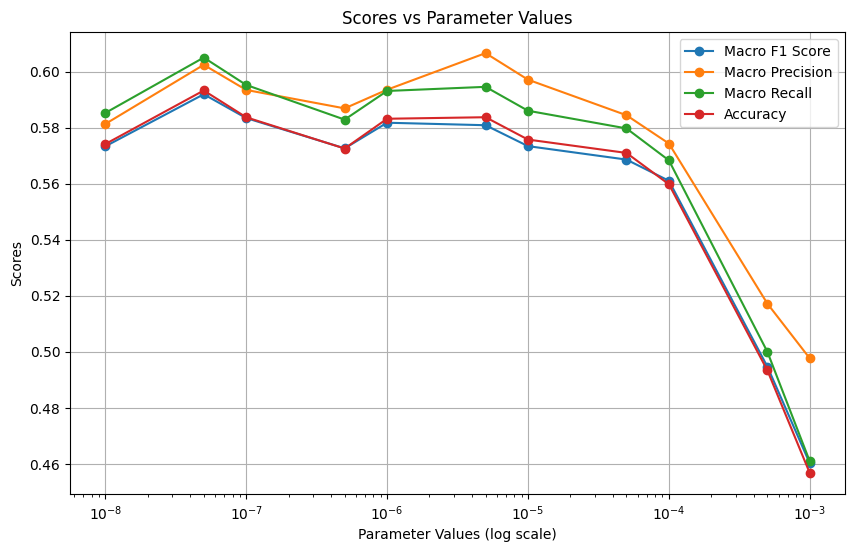

In [31]:
# Plot the obtained results
plt.figure(figsize=(10, 6))
parameters = [value["detector__threshold"] for value in results_threshold["params"]]

plt.plot(parameters, results_threshold["mean_test_f1"], label='Macro F1 Score', marker='o')
plt.plot(parameters, results_threshold["mean_test_precision"], label='Macro Precision', marker='o')
plt.plot(parameters, results_threshold["mean_test_recall"], label='Macro Recall', marker='o')
plt.plot(parameters, results_threshold["mean_test_accuracy"], label='Accuracy', marker='o')

plt.xscale('log')  # Set X axis to logarithmic scale
plt.xlabel('Parameter Values (log scale)')
plt.ylabel('Scores')
plt.title('Scores vs Parameter Values')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Save data
pickle.dump(grid_search, open('part1_grid_search.dat', 'wb'))

### Conclusions:

In general, we can observe that as long as we decrease the threshold we get better results for all metrics (accuracy, precision, recall, f1). This is because as threshold decreases, we employ more features to describe the image and consequently, we have more information in order to further on do the classification.

## 2. Using DenseSIFT instead of Kaze features detector

Now, we are going to change the detector used, now let's try the Dense SIFT detector. 

For this detector, we need to select two parameters: step and scale. The step is the distance between two keypoints and the scale, their size.

In this case, we set the `detector__step` and `detector__scale` parameters with different values to look for the combination which provide us better results in terms of accuracy.

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=10)
kmeans_codebook = KmeansCodebook(128)
knn_classifier = KNNClassifier(5)

model = CustomModel(DSIFT_detector, kmeans_codebook, knn_classifier)

# Define parameters grid with the values we want to test
step_values = [5, 10, 20]
scale_values = [3, 5, 10, 15]
parameters_grid = {'detector__step': step_values, 'detector__scale': scale_values}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_dsift = grid_search.cv_results_

In [6]:
# Save data
pickle.dump(grid_search, open('part2_grid_search.dat', 'wb'))

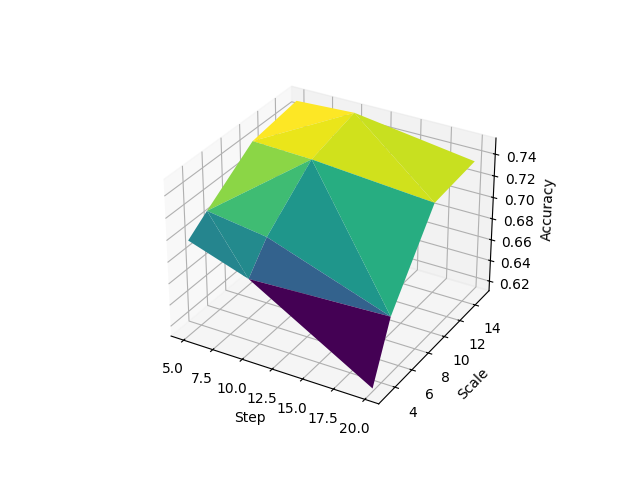

In [39]:
accuracy_values = np.array(results_dsift["mean_test_accuracy"], dtype=np.float64)
step_values = np.array(results_dsift["param_detector__step"], dtype=np.float64)
scale_values = np.array(results_dsift["param_detector__scale"], dtype=np.float64)

# Create a 3D plot to show the obtained results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_trisurf(step_values, scale_values, accuracy_values, cmap='viridis', edgecolor='none')

ax.set_xlabel('Step')
ax.set_ylabel('Scale')
ax.set_zlabel('Accuracy')

plt.show()

### Conclusions:

In the figure we can clearly see that we get a lower accuracy by increasing the number of steps. It happens de same by decreasing the scale, the accuracy gets worse.
These results make sense because they indicate that with keypoints with less characteristics and higher the distance between the keypoints or, in other words, with less and smaller keypoints, the results are worse.

## 3. Using norm and scaler

In this part, we are going to use a norms and scalers to normalize or scale the descriptors the detector gives us. Since the results of the Dense SIFT detector were better than the KAZE detector ones, we will use Dense SIFT from now on. 

To normalize or scale, we will use the classes `Normalizer`, `StandardScaler` and `MinMaxScaler` with different parameters, as can be seen in the first line of code of the following cell. 

In [ ]:
# Define normalizers and scalers to test
normalizer = [Normalizer(norm = 'l2'),Normalizer(norm = 'l1'),Normalizer(norm = 'max'),
                StandardScaler(),MinMaxScaler(),MinMaxScaler(feature_range=(-1,1))]

first_normalizer = normalizer[0]

# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15, standardizer=first_normalizer)
kmeans_codebook = KmeansCodebook(128)
knn_classifier = KNNClassifier(5)
 
model = CustomModel(DSIFT_detector, kmeans_codebook, knn_classifier)
 
# Define parameters grid with the values we want to test
parameters_grid = {'detector__stand': normalizer} 

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)
 
print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)
 
results_norm_scaler = grid_search.cv_results_

In [14]:
# Save data
pickle.dump(grid_search, open('part3_grid_search.dat', 'wb'))

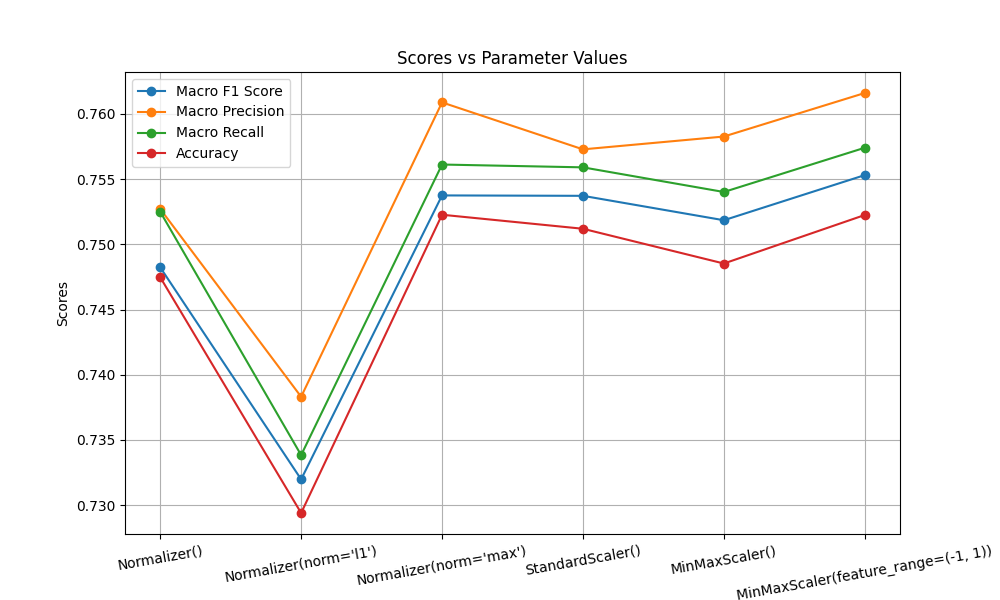

In [41]:
# Plot the obtained results
plt.figure(figsize=(10, 6))
parameters = [str(value["detector__stand"]) for value in results_norm_scaler["params"]]

plt.plot(parameters, results_norm_scaler["mean_test_f1"], label='Macro F1 Score', marker='o')
plt.plot(parameters, results_norm_scaler["mean_test_precision"], label='Macro Precision', marker='o')
plt.plot(parameters, results_norm_scaler["mean_test_recall"], label='Macro Recall', marker='o')
plt.plot(parameters, results_norm_scaler["mean_test_accuracy"], label='Accuracy', marker='o')

plt.xticks(rotation=10)
plt.xlabel('Normalizers')
plt.ylabel('Scores')
plt.title('Scores vs Parameter Values')
plt.legend()
plt.grid(True)
plt.show()

### Conclusions:

The best accuracy, 75.53%, is obtained with the MinMaxScaler when each feature is scaled and translated in the range of [-1,1].  

## 4. Testing different amounts of codebook sizes.

In this step, we aim to determine which is the codebook size, i.e, the dimensionality of the feature space that provides a better representation of the data. Again, we used `sklearn.GridSearchCV()` to cross validate the obtained results for each K. 


In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(128)
knn_classifier = KNNClassifier(5)

model = CustomModel(DSIFT_detector, kmeans_codebook, knn_classifier)

# Define parameters grid with the values we want to test
codebook_sizes = [64, 128, 256, 512, 1024, 2048]
parameters_grid = {'codebook__n_clusters': codebook_sizes}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_codebook_sz = grid_search.cv_results_

In [5]:
# Save data
pickle.dump(grid_search, open('part4_grid_search.dat', 'wb'))

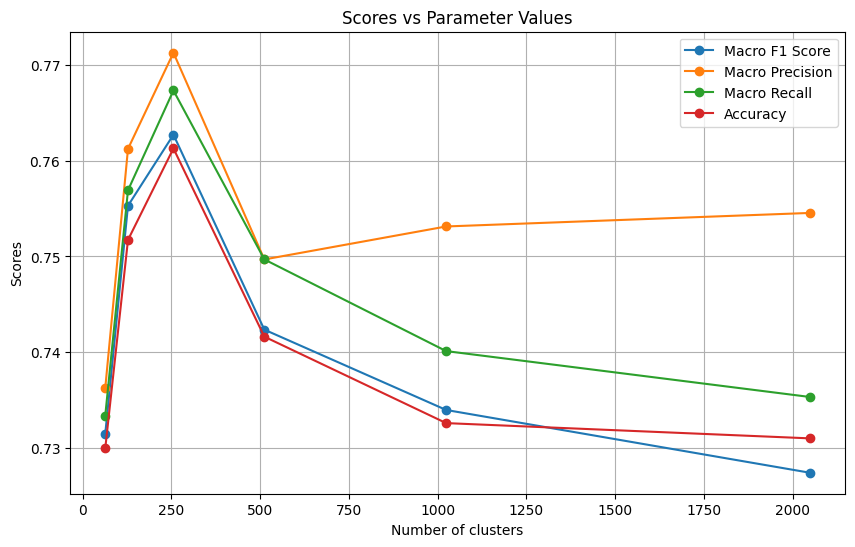

In [26]:
# Plot the obtained results
plt.figure(figsize=(10, 6))
parameters = [value["codebook__n_clusters"] for value in results_codebook_sz["params"]]

plt.plot(parameters, results_codebook_sz["mean_test_f1"], label='Macro F1 Score', marker='o')
plt.plot(parameters, results_codebook_sz["mean_test_precision"], label='Macro Precision', marker='o')
plt.plot(parameters, results_codebook_sz["mean_test_recall"], label='Macro Recall', marker='o')
plt.plot(parameters, results_codebook_sz["mean_test_accuracy"], label='Accuracy', marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.title('Scores vs Parameter Values')
plt.legend()
plt.grid(True)
plt.show()

### Conclusions:

From a plot above we can see that the codebook size that best charactherize each class is 256. Note that, when K is smaller than 256, accuracy decreases. This is attributed to the limitation of Bag-of-Visual-Words in characterizing each class with a small K. Conversely, for K values exceeding 256, the curse of dimensionality becomes evident, impacting performance

## 5. Testing different values of k for the k-nn classifier.

We are going to try with different numbers of neighbors for the k-nn classifier and see which one performs best. 

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
knn_classifier = KNNClassifier(5)

model = CustomModel(DSIFT_detector, kmeans_codebook, knn_classifier)

# Define parameters grid with the values we want to test
k_values = [3, 5, 7, 13, 17, 19, 23, 31, 67, 89, 127]
parameters_grid = {'classifier__n_neighbors': k_values}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_knn_values = grid_search.cv_results_

In [27]:
# Save data
pickle.dump(grid_search, open('part5_grid_search.dat', 'wb'))

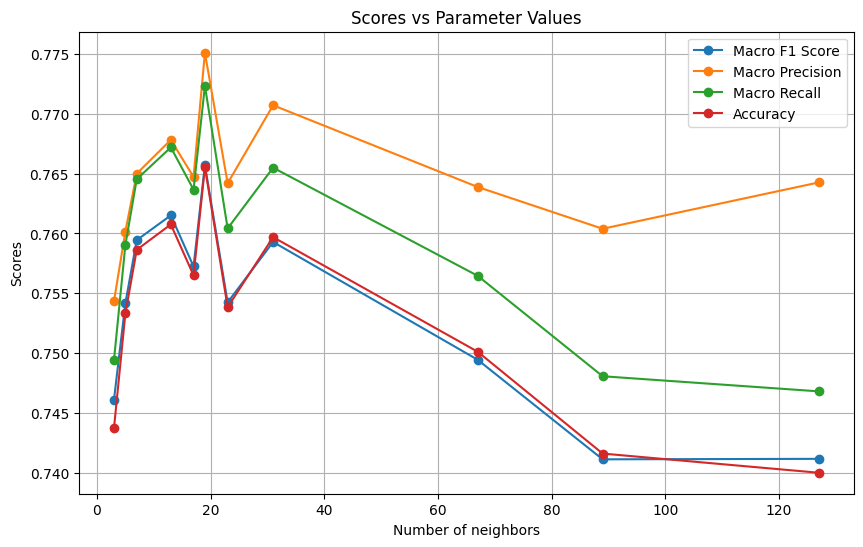

In [28]:
# Plot the obtained results
plt.figure(figsize=(10, 6))
parameters = [value["classifier__n_neighbors"] for value in results_knn_values["params"]]

plt.plot(parameters, results_knn_values["mean_test_f1"], label='Macro F1 Score', marker='o')
plt.plot(parameters, results_knn_values["mean_test_precision"], label='Macro Precision', marker='o')
plt.plot(parameters, results_knn_values["mean_test_recall"], label='Macro Recall', marker='o')
plt.plot(parameters, results_knn_values["mean_test_accuracy"], label='Accuracy', marker='o')

plt.xlabel('Number of neighbors')
plt.ylabel('Scores')
plt.title('Scores vs Parameter Values')
plt.legend()
plt.grid(True)
plt.show()

### Conclusions:

As we can see in the graph above, the number of neighbors that performs best is 19 (around 20). We can also see two different things that were to be expected: if we use a very low number or a very high number of neighbors, the performance of the system gets worse. 

## 6. Testing other distances for the k-nn classifier.

The distance metrics determines how the decision boundaries are formed between the different classes.  We are going to test different types of distances for the k-nn classifier, and see with which one it performs best. 

We tried with the following ones: `manhattan`, `euclidean` (the one we have used until now), `minkowski`, `chebyshev`, `cosine`, `hamming`, `canberra`, `braycurtis` and `dice`.

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
knn_classifier = KNNClassifier(19)

model = CustomModel(DSIFT_detector, kmeans_codebook, knn_classifier)

# Define parameters grid with the values we want to test
distances = ['manhattan', 'euclidean', 'minkowski', 'chebyshev', 'cosine', 'hamming', 'canberra', 'braycurtis', 'dice']  # default -> 'minkowski'
parameters_grid = {'classifier__metric': distances}

# We need to use a LabelEncoder because some distances gave us some problems with the string labels (e.g. 'manhattan')
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels_encoded)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_knn_distances = grid_search.cv_results_

In [4]:
# Save data
pickle.dump(grid_search, open('part6_grid_search.dat', 'wb'))

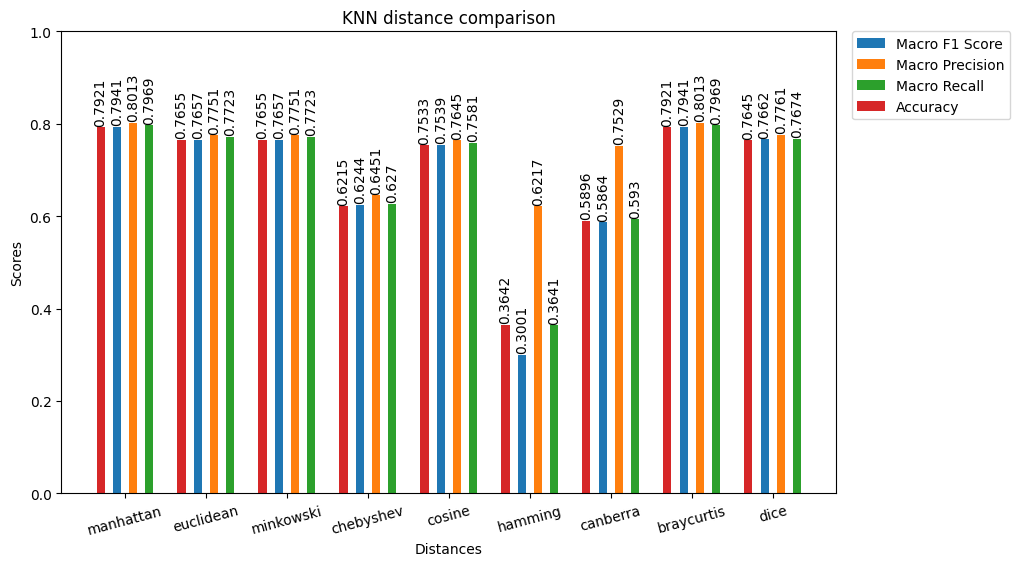

In [16]:
x_positions = np.arange(len(distances))

# Set the width of the bars
bar_width = 0.1
group_spacing = 0.1

fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot to show the obtained results
plt.bar(x_positions - 0.5 * (bar_width + group_spacing), results_knn_distances["mean_test_f1"], width=bar_width, label='Macro F1 Score')
plt.bar(x_positions + 0.5 * (bar_width + group_spacing), results_knn_distances["mean_test_precision"], width=bar_width, label='Macro Precision')
plt.bar(x_positions + 1.5 * (bar_width + group_spacing), results_knn_distances["mean_test_recall"], width=bar_width, label='Macro Recall')
plt.bar(x_positions - 1.5 * (bar_width + group_spacing), results_knn_distances["mean_test_accuracy"], width=bar_width, label='Accuracy')

for i in range(len(results_knn_distances["mean_test_f1"])):
    plt.text(x_positions[i] - 0.5 * (bar_width + group_spacing), results_knn_distances["mean_test_f1"][i] + 0.01, round(results_knn_distances["mean_test_f1"][i], 4), rotation=90, ha='center')

for i in range(len(results_knn_distances["mean_test_precision"])):
    plt.text(x_positions[i] + 0.5 * (bar_width + group_spacing), results_knn_distances["mean_test_precision"][i] + 0.01, round(results_knn_distances["mean_test_precision"][i], 4), rotation=90,ha='center')

for i in range(len(results_knn_distances["mean_test_recall"])):
    plt.text(x_positions[i] + 1.5 * (bar_width + group_spacing), results_knn_distances["mean_test_recall"][i] + 0.01, round(results_knn_distances["mean_test_recall"][i], 4), rotation=90, ha='center')

for i in range(len(results_knn_distances["mean_test_accuracy"])):
    plt.text(x_positions[i] - 1.5 * (bar_width + group_spacing), results_knn_distances["mean_test_accuracy"][i] + 0.01, round(results_knn_distances["mean_test_accuracy"][i], 4), rotation=90, ha='center')


# Add labels and title
plt.xticks(rotation=15)
plt.xlabel('Distances')
plt.ylim(0, 1)
plt.ylabel('Scores')
plt.title('KNN distance comparison')
plt.xticks(x_positions, distances)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Conclusions:

As the previous table suggests, the `manhattan` and `braycurtis` distances were the ones that gave the best results, with the same values for the metrics. We assume that this happens because they are similar distances although Braycurtis scale the distance while manhattan not. They reached a 79\% of accuracy, precision and recall, going above the 80% for the f1-score. 

## 7. Testing on SVM classifier.

Now, we will replace the KNN classifier with the SVM classifier, trying three different kernels for it: Linear kernel, Radial Basis Function(RBF) kernel and a Histogram Intersection kernel(*). 

(*) Histogram Intersection kernel has been programmed by us, as it is not implemented in sklearn.

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
svm_classifier = SVMClassifier(kernel='linear')

model = CustomModel(DSIFT_detector, kmeans_codebook, svm_classifier)

# Define parameters grid with the values we want to test
kernels = ['linear', 'rbf', 'histogram_intersection']
parameters_grid = {'classifier__kernel': kernels}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_spatial_pyramid = grid_search.cv_results_

In [6]:
# Save data
pickle.dump(grid_search, open('part7_grid_search.dat', 'wb'))

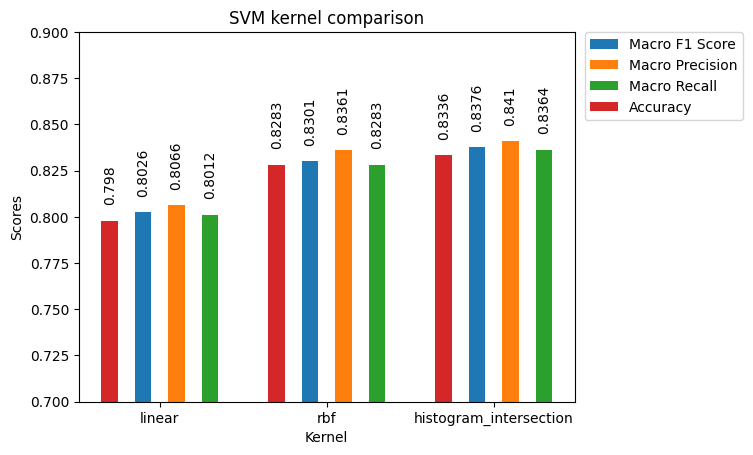

In [12]:
x_positions = np.arange(len(kernels))

# Set the width of the bars
bar_width = 0.1
group_spacing = 0.1

# Create the bar plot to show the obtained results
plt.bar(x_positions - 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_f1"], width=bar_width, label='Macro F1 Score')
plt.bar(x_positions + 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_precision"], width=bar_width, label='Macro Precision')
plt.bar(x_positions + 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_recall"], width=bar_width, label='Macro Recall')
plt.bar(x_positions - 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_accuracy"], width=bar_width, label='Accuracy')

for i in range(len(results_spatial_pyramid["mean_test_f1"])):
    plt.text(x_positions[i] - 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_f1"][i] + 0.01, round(results_spatial_pyramid["mean_test_f1"][i], 4), rotation=90, ha='center')

for i in range(len(results_spatial_pyramid["mean_test_precision"])):
    plt.text(x_positions[i] + 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_precision"][i] + 0.01, round(results_spatial_pyramid["mean_test_precision"][i], 4), rotation=90,ha='center')

for i in range(len(results_spatial_pyramid["mean_test_recall"])):
    plt.text(x_positions[i] + 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_recall"][i] + 0.01, round(results_spatial_pyramid["mean_test_recall"][i], 4), rotation=90, ha='center')

for i in range(len(results_spatial_pyramid["mean_test_accuracy"])):
    plt.text(x_positions[i] - 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_accuracy"][i] + 0.01, round(results_spatial_pyramid["mean_test_accuracy"][i], 4), rotation=90, ha='center')


# Add labels and title
plt.xlabel('Kernel')
plt.ylabel('Scores')
plt.title('SVM kernel comparison')
plt.ylim(0.7, 0.9)
plt.xticks(x_positions, kernels)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Conclusions:

As expected, the Linear kernel performance is the worst because the boundaries between classes are non-linear. Since RBF and the Histogram intersection kernels are non-linear, they performed better, with the Histogram Intersection one providing the best results. 

Also, by comparing these results to the ones we had seen until now with the k-nn classifier, we can conclude that the SVM classifier enhances the system's performace. 

## 8. Dimensionality reduction

We will see how a reduction in the dimensionality of the visual words can affect at the performance of the model. First, we will attempt with a PCA, trying different numbers of components for it. 

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
svm_classifier = SVMClassifier(kernel='histogram_intersection')
dim_reduction = PCA(n_components=64)

model = CustomModel(DSIFT_detector, kmeans_codebook, svm_classifier, dim_reduction=dim_reduction)

# Define parameters grid with the values we want to test
parameters_grid = {'dim_reduction__n_components': [16, 32, 64, 128, 256]}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_pca = grid_search.cv_results_

In [5]:
# Save data
pickle.dump(grid_search, open('part8.1_grid_search.dat', 'wb'))

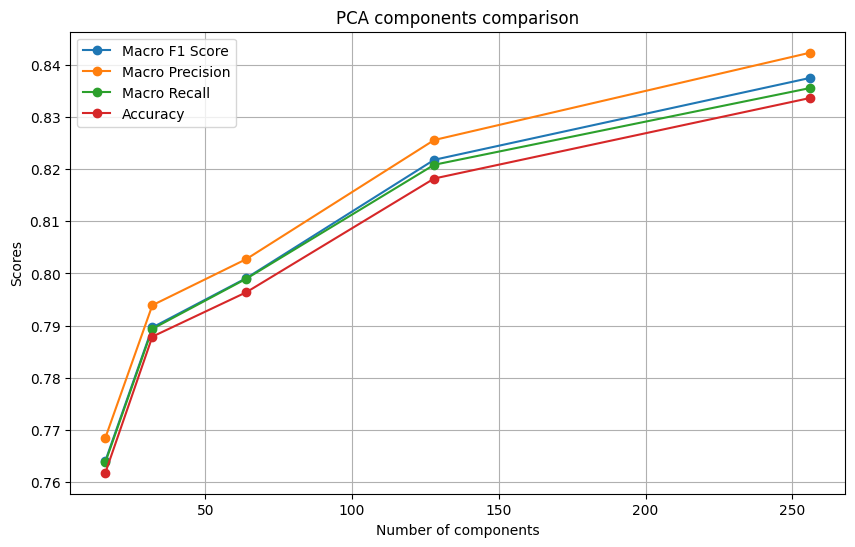

In [24]:
# Plot the obtained results
plt.figure(figsize=(10, 6))
parameters = [value["dim_reduction__n_components"] for value in results_pca["params"]]

plt.plot(parameters, results_pca["mean_test_f1"], label='Macro F1 Score', marker='o')
plt.plot(parameters, results_pca["mean_test_precision"], label='Macro Precision', marker='o')
plt.plot(parameters, results_pca["mean_test_recall"], label='Macro Recall', marker='o')
plt.plot(parameters, results_pca["mean_test_accuracy"], label='Accuracy', marker='o')

plt.xlabel('Number of components')
plt.ylabel('Scores')
plt.title('PCA components comparison')
plt.legend()
plt.grid(True)
plt.show()

Now, we will see how the performance is affected by an LDA dimensionality reduction. We will also try with different numbers of components, knowing that the maximum has to be the number of classes minus 1. 

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
svm_classifier = SVMClassifier(kernel='histogram_intersection')
dim_reduction = LinearDiscriminantAnalysis(n_components=7)

model = CustomModel(DSIFT_detector, kmeans_codebook, svm_classifier, dim_reduction=dim_reduction)

# Define parameters grid with the values we want to test
parameters_grid = {'dim_reduction__n_components': [1, 2, 3, 4, 5, 6, 7]}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_lda = grid_search.cv_results_

In [21]:
# Save data
pickle.dump(grid_search, open('part8.2_grid_search.dat', 'wb'))

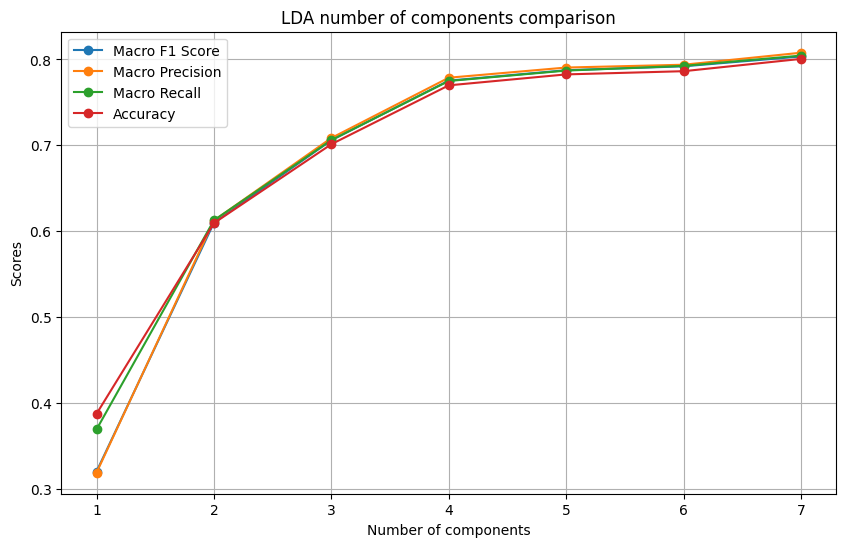

In [23]:
# Plot the obtained results
plt.figure(figsize=(10, 6))
parameters = [value["dim_reduction__n_components"] for value in results_lda["params"]]

plt.plot(parameters, results_lda["mean_test_f1"], label='Macro F1 Score', marker='o')
plt.plot(parameters, results_lda["mean_test_precision"], label='Macro Precision', marker='o')
plt.plot(parameters, results_lda["mean_test_recall"], label='Macro Recall', marker='o')
plt.plot(parameters, results_lda["mean_test_accuracy"], label='Accuracy', marker='o')

plt.xlabel('Number of components')
plt.ylabel('Scores')
plt.title('LDA number of components comparison')
plt.legend()
plt.grid(True)
plt.show()

### Conclusions:

The best results obtained with both dimensionality reductions were with the PCA and 256 dimensions which, actually, was the original number of dimensions. The maximum with the LDA was an 80% in all metrics, approximately. In both cases, the bigger the reduction, the worse the results. We can conclude that a dimensionality reduction is not improving the performance of our system. 

## 9. Spatial pyramids


Now, we are going to try with the spatial pyramids: dividing the image in sub-images and concatenating the histograms of the visual words of each sub-image to create a descriptor for the classifier that tries to keep some spatial information. 

IMPORTANT: we changed the kernel of the SVM classifier because the histogram intersection kernel was implemented by us and, with the dimensions of the histograms being bigger with the spatial pyramid, it gave memory problems. Since the RBF kernel gave very similar results as the histogram intersection one, we will use that one instead. 

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
# We use 'rbf' as the kernel because histogram_intersection was created by us and gave memory problems
svm_classifier = SVMClassifier(kernel='rbf')

model = CustomModel(DSIFT_detector, kmeans_codebook, svm_classifier, spatial_pyramid=(2, 2))

# Define parameters grid with the values we want to test
parameters_grid = {'spatial_pyramid__levels': [(2, 2), (4, 4)]}

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_spatial_pyramid = grid_search.cv_results_

In [26]:
# Save data
pickle.dump(grid_search, open('part9_grid_search.dat', 'wb'))

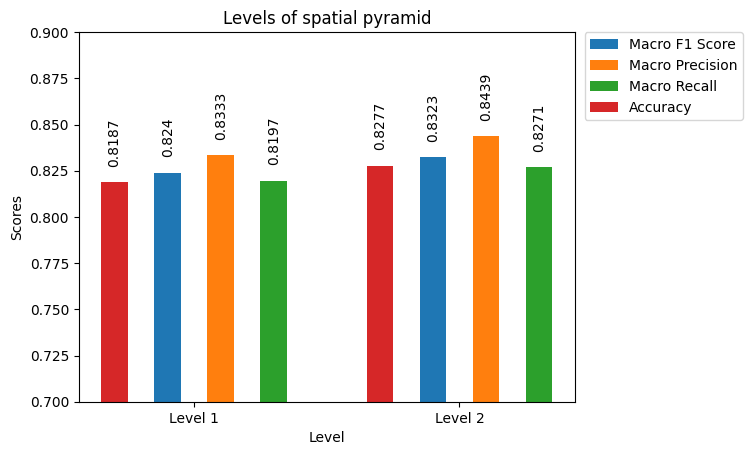

In [17]:
x_positions = np.arange(2)

# Set the width of the bars
bar_width = 0.1
group_spacing = 0.1

# Create the bar plot to show the obtained results
plt.bar(x_positions - 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_f1"], width=bar_width, label='Macro F1 Score')
plt.bar(x_positions + 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_precision"], width=bar_width, label='Macro Precision')
plt.bar(x_positions + 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_recall"], width=bar_width, label='Macro Recall')
plt.bar(x_positions - 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_accuracy"], width=bar_width, label='Accuracy')

for i in range(len(results_spatial_pyramid["mean_test_f1"])):
    plt.text(x_positions[i] - 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_f1"][i] + 0.01, round(results_spatial_pyramid["mean_test_f1"][i], 4), rotation=90, ha='center')

for i in range(len(results_spatial_pyramid["mean_test_precision"])):
    plt.text(x_positions[i] + 0.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_precision"][i] + 0.01, round(results_spatial_pyramid["mean_test_precision"][i], 4), rotation=90,ha='center')

for i in range(len(results_spatial_pyramid["mean_test_recall"])):
    plt.text(x_positions[i] + 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_recall"][i] + 0.01, round(results_spatial_pyramid["mean_test_recall"][i], 4), rotation=90, ha='center')

for i in range(len(results_spatial_pyramid["mean_test_accuracy"])):
    plt.text(x_positions[i] - 1.5 * (bar_width + group_spacing), results_spatial_pyramid["mean_test_accuracy"][i] + 0.01, round(results_spatial_pyramid["mean_test_accuracy"][i], 4), rotation=90, ha='center')


# Add labels and title
plt.xlabel('Level')
plt.ylabel('Scores')
plt.title('Levels of spatial pyramid')
plt.ylim(0.7, 0.9)
plt.xticks(x_positions, ["Level 1", "Level 2"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Conclusions: 
 
The results show that doing the spatial pyramids did not contribute to improving the model. The results are better with the second level of the spatial pyramid, but they do not improve the results of doing it without dividing the image. Only the Macro precision is better than before. Since it is more computationally expensive, we will not use the spatial pyramids anymore. 

## 10. Improving the model


As a last try to enhance the system, we have tested different combinations of some of the parameters related to the dimensionality reduction.


### Spatial Pyramids and PCA.
#### Codebook size: 32.
The first graphic shows the results we obtained by using 32 clusters as codebook size for K-Means. We have tested four combinations with the number of components (DR) and the spatial pyramid levels (SP).
-  DR: [8,16]
-  SP: (2,2),(4,4)

The best performance is obtained from [16,(4,4)] combination with an accuracy of 74.32%. We can state that all the results are worse than in the previous cases, so we are not improving the system with these combinations.
#### Codebook size: 64.
We have repeated the previous experiment by using 64 clusters as codebook size for K-Means. Again, we have tested combinations with the number of components (DR) and the spatial pyramid levels (SP):
- DR:  [8,16,32]
- SP: (2,2), (4,4)

The best performance is obtained from [32,(2,2)] combination with an accuracy of 78.1%. We can conclude that the outcomes for all combinations are inferior compared to the previous cases. Consequently, it is evident that these combinations are not enhancing the system.

#### Codebook size: 128.
Finally, we’ve repeated the same experiment by using 128 clusters as codebook size for K-Means. Again, we have tested combinations with the number of components (DR) and the spatial pyramid levels (SP):
- DR:  [8,16,32,64]
- SP: (2,2), (4,4)

The best performance is obtained from [64,(4,4)] with an accuracy of 80.33%. As well, the outcomes for all combinations are worse than in the previous cases, that is, we are not improving the system in this way.

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
# We use 'rbf' as the kernel because histogram_intersection was created by us and gave memory problems
svm_classifier = SVMClassifier(kernel='rbf')
pca = PCA(n_components=64)

model = CustomModel(DSIFT_detector, kmeans_codebook, svm_classifier, dim_reduction=pca, spatial_pyramid=(2, 2))

# Define parameters grid with the values we want to test
parameters_grid = [
    {'codebook__n_clusters': [128],
                     'dim_reduction__n_components': [8, 16, 32, 64],
                     'spatial_pyramid__levels': [(2, 2), (4, 4)]}, 
    {'codebook__n_clusters': [64],
                     'dim_reduction__n_components': [8, 16, 32],
                     'spatial_pyramid__levels': [(2, 2), (4, 4)]}, 
    {'codebook__n_clusters': [32],
                     'dim_reduction__n_components': [8, 16],
                     'spatial_pyramid__levels': [(2, 2), (4, 4)]},

]

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_improving = grid_search.cv_results_

In [31]:
# Save data
pickle.dump(grid_search, open('part10_1st_grid_search.dat', 'wb'))

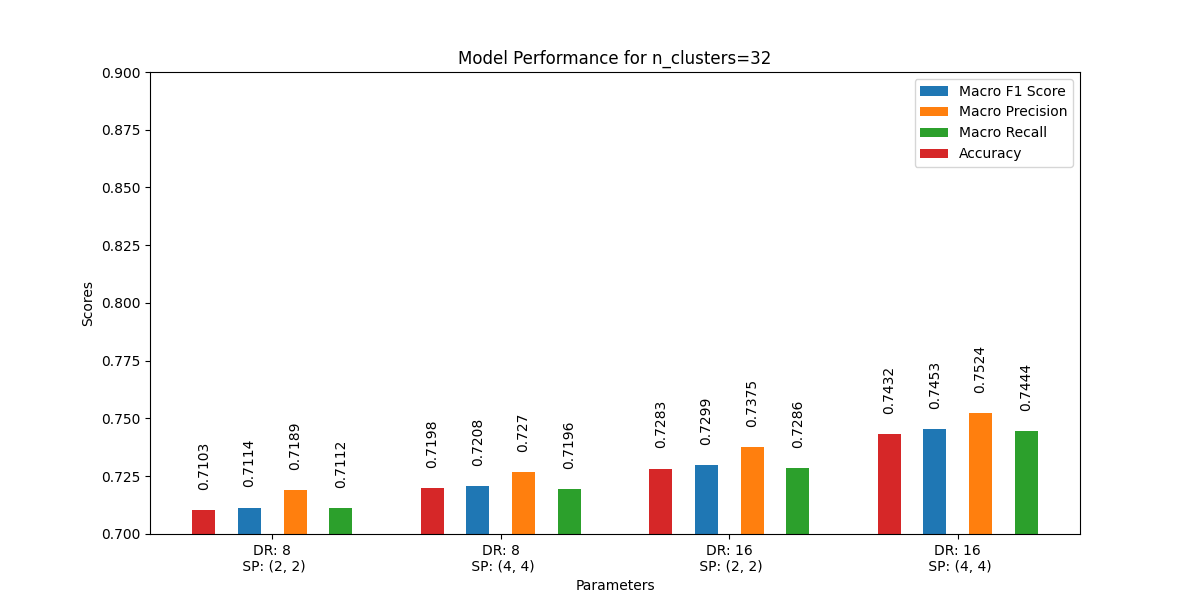

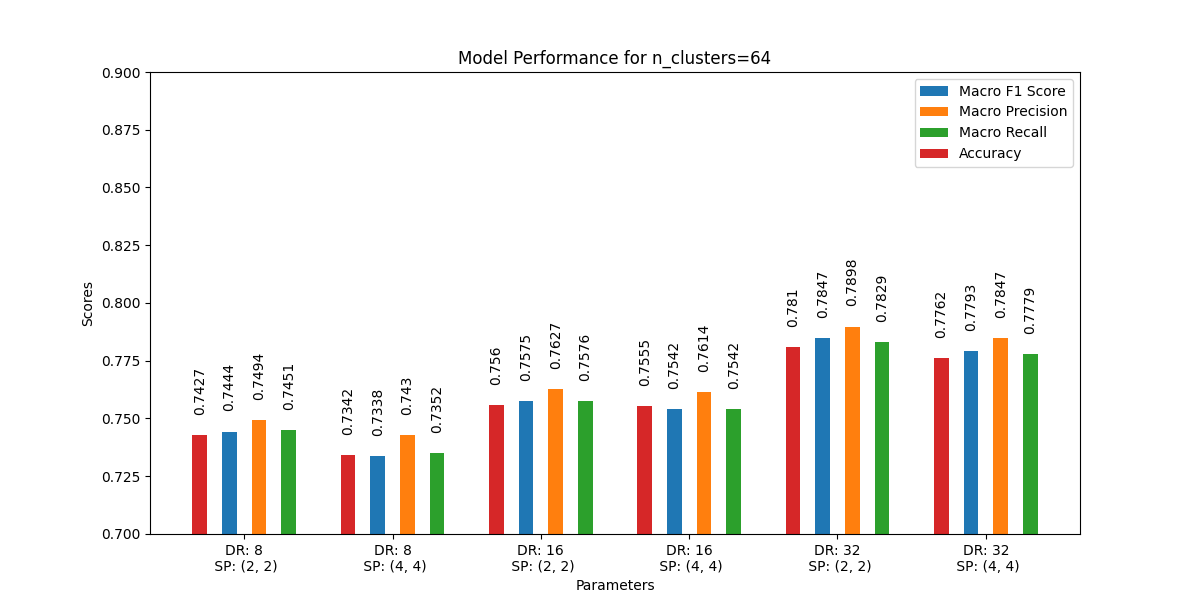

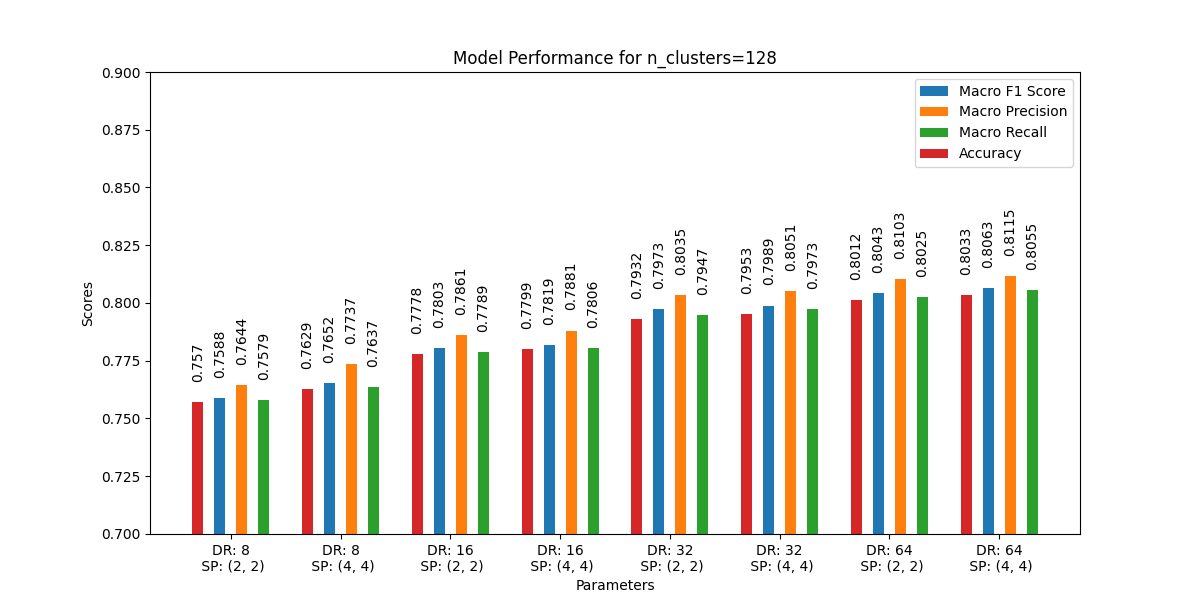

In [32]:
# Extract the relevant data from the results
n_clusters = [param['codebook__n_clusters'] for param in results_improving['params']]
dim_reduction = [param['dim_reduction__n_components'] for param in results_improving['params']]
spatial_pyramid = [param['spatial_pyramid__levels'] for param in results_improving['params']]
accuracy = results_improving['mean_test_accuracy']
f1 = results_improving['mean_test_f1']
precision = results_improving['mean_test_precision']
recall = results_improving['mean_test_recall']

# Get unique values of n_clusters
unique_clusters = np.unique(n_clusters)

# Create a separate plot for each value of n_clusters
for cluster in unique_clusters:
    # Filter the data for the current n_clusters value
    cluster_indices = [i for i, c in enumerate(n_clusters) if c == cluster]
    cluster_dim_reduction = [dim_reduction[i] for i in cluster_indices]
    cluster_spatial_pyramid = [spatial_pyramid[i] for i in cluster_indices]
    cluster_accuracy = [accuracy[i] for i in cluster_indices]
    cluster_f1 = [f1[i] for i in cluster_indices]
    cluster_precision = [precision[i] for i in cluster_indices]
    cluster_recall = [recall[i] for i in cluster_indices]
    
    # Set the width of the bars
    bar_width = 0.1
    group_spacing = 0.1
    
    # Create a wider figure
    plt.figure(figsize=(12, 6))
    
    # Create the bar plot for accuracy
    x_positions = np.arange(len(cluster_dim_reduction))
    
    
    # Create the line plot for f1
    plt.bar(x_positions - 0.5 * (bar_width + group_spacing), cluster_f1, width=bar_width, label='Macro F1 Score')
    
    # Create the line plot for precision
    plt.bar(x_positions + 0.5 * (bar_width + group_spacing), cluster_precision, width=bar_width, label='Macro Precision')
    
    # Create the line plot for recall
    plt.bar(x_positions + 1.5 * (bar_width + group_spacing), cluster_recall, width=bar_width, label='Macro Recall')

    # Create the line plot for accuracy
    plt.bar(x_positions - 1.5 * (bar_width + group_spacing), cluster_accuracy, width=bar_width, label='Accuracy')
    
    # Add labels and title
    plt.xlabel('Parameters')
    plt.ylabel('Scores')
    plt.title(f'Model Performance for n_clusters={cluster}')
    plt.ylim(0.7, 0.9)
    
    # Set the x-axis ticks and labels
    plt.xticks(x_positions, [f'DR: {d}\n SP: {s}' for d, s in zip(cluster_dim_reduction, cluster_spatial_pyramid)])
    
    # Add value labels to the top of each bar
    for i, f1_score in enumerate(cluster_f1):
        plt.text(x_positions[i] - 0.5 * (bar_width + group_spacing), f1_score + 0.01, round(f1_score, 4), rotation=90, ha='center')
    for i, prec in enumerate(cluster_precision):
        plt.text(x_positions[i] + 0.5 * (bar_width + group_spacing), prec + 0.01, round(prec, 4), rotation=90, ha='center')
    for i, rec in enumerate(cluster_recall):
        plt.text(x_positions[i] + 1.5 * (bar_width + group_spacing), rec + 0.01, round(rec, 4), rotation=90, ha='center')
    for i, acc in enumerate(cluster_accuracy):
        plt.text(x_positions[i] - 1.5 * (bar_width + group_spacing), acc + 0.01, round(acc, 4), rotation=90, ha='center')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()


### Spatial Pyramids and LDA.
We have tested different combinations with the number of components (DR) and the spatial pyramid levels (SP) and using different number of clusters(K).
-  K: [32,64,128]
-  DR: [5, 6, 7]
-  SP: (2,2),(4,4)

For K = 32, the best performance is obtained from [32,7,(2,2)] combination with an accuracy of 74.32%. We can state that all the results are worse than in the previous cases, so we are not improving the system with these combinations.

For K = 64, the best performance is obtained from [64,7,(2,2)] combination with an accuracy of 77.35%. We can state that all the results are worse than in the previous cases, so we are not improving the system with these combinations.

For K = 128, the best performance is obtained from [128,7,(2,2)] combination with an accuracy of 77.09%. We can state that all the results are worse than in the previous cases, so we are not improving the system with these combinations.

In [ ]:
# Create model with the detector, codebook and classifier we want to use
DSIFT_detector = DenseSiftDetector(step=10, scale=15)
kmeans_codebook = KmeansCodebook(256)
# We use 'rbf' as the kernel because histogram_intersection was created by us and gave memory problems
svm_classifier = SVMClassifier(kernel='rbf')
lda = LinearDiscriminantAnalysis(n_components=7)

model = CustomModel(DSIFT_detector, kmeans_codebook, svm_classifier, dim_reduction=lda, spatial_pyramid=(2, 2))

# Define parameters grid with the values we want to test
parameters_grid = [
    {'codebook__n_clusters': [128],
                     'dim_reduction__n_components': [5, 6, 7],
                     'spatial_pyramid__levels': [(2, 2), (4, 4)]}, 
    {'codebook__n_clusters': [64],
                     'dim_reduction__n_components': [5, 6, 7],
                     'spatial_pyramid__levels': [(2, 2), (4, 4)]}, 
    {'codebook__n_clusters': [32],
                     'dim_reduction__n_components': [5, 6, 7],
                     'spatial_pyramid__levels': [(2, 2), (4, 4)]},

]

# Define the metrics we want to obtain from the grid search
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'precision': 'precision_macro', 'recall': 'recall_macro'}

# Perform grid search with cross-validation in order to evaluate the performance of the values to test
grid_search = GridSearchCV(model, parameters_grid, cv=5, verbose=1, n_jobs=1, scoring=scoring, refit='f1')
grid_search.fit(train_images_filenames, train_labels)

print('Best score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

results_improving = grid_search.cv_results_

In [34]:
# Save data
pickle.dump(grid_search, open('part10_2nd_grid_search.dat', 'wb'))

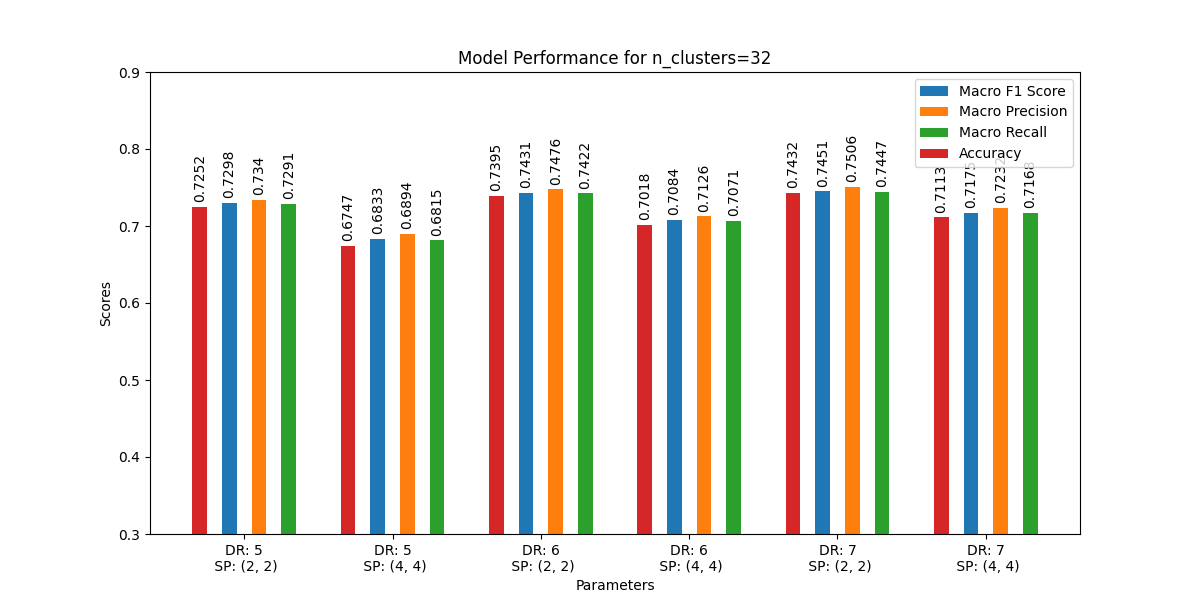

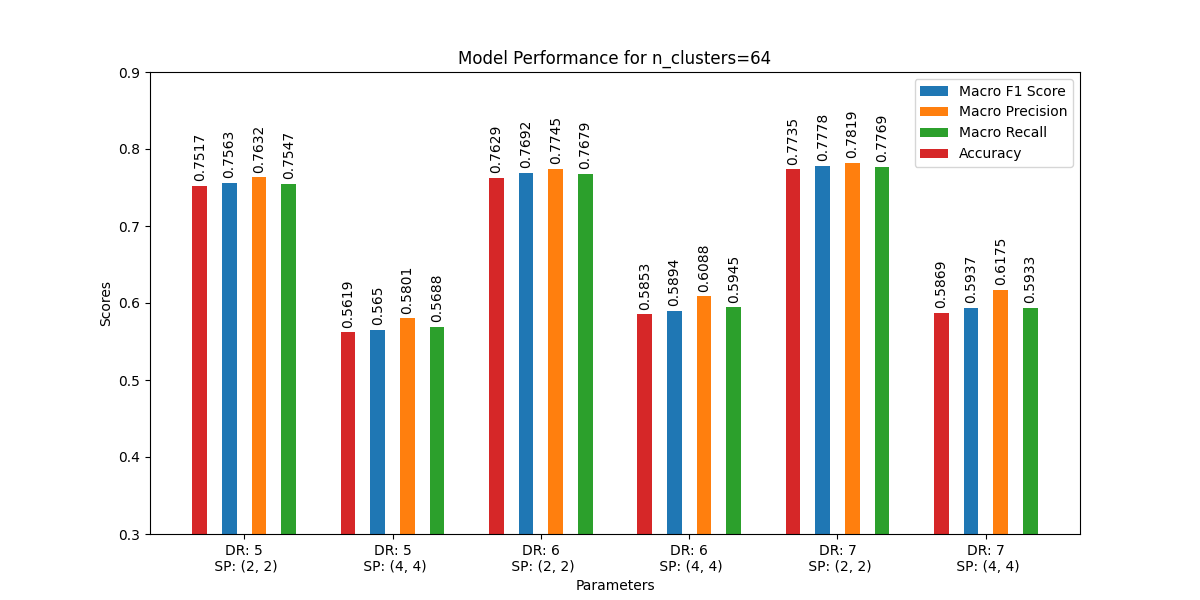

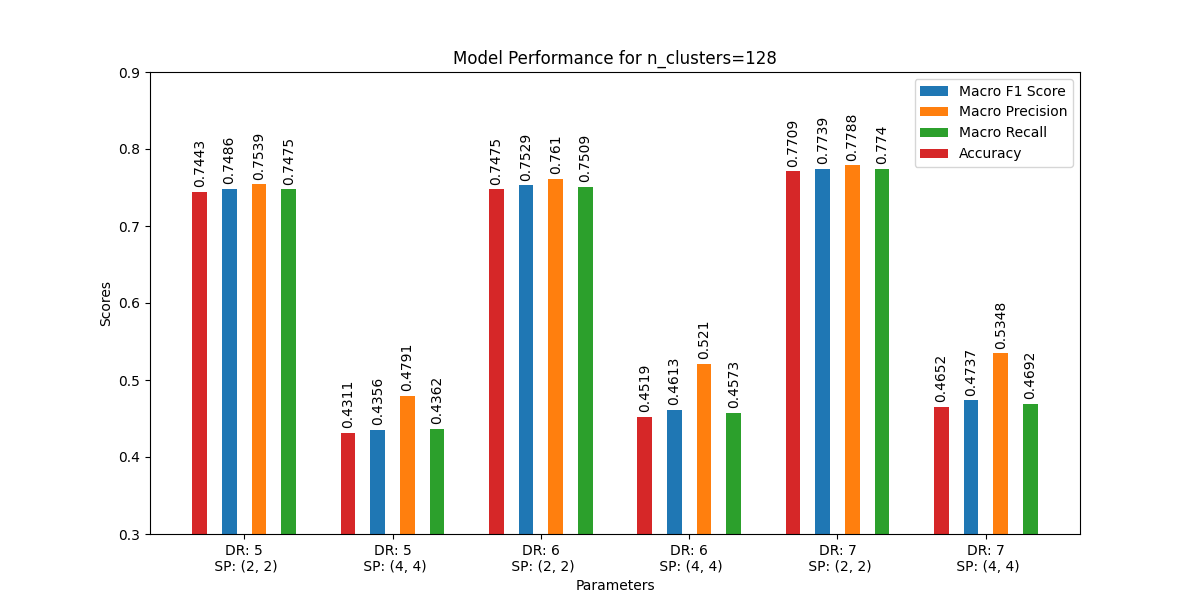

In [37]:
# Extract the relevant data from the results
n_clusters = [param['codebook__n_clusters'] for param in results_improving['params']]
dim_reduction = [param['dim_reduction__n_components'] for param in results_improving['params']]
spatial_pyramid = [param['spatial_pyramid__levels'] for param in results_improving['params']]
accuracy = results_improving['mean_test_accuracy']
f1 = results_improving['mean_test_f1']
precision = results_improving['mean_test_precision']
recall = results_improving['mean_test_recall']

# Get unique values of n_clusters
unique_clusters = np.unique(n_clusters)

# Create a separate plot for each value of n_clusters
for cluster in unique_clusters:
    # Filter the data for the current n_clusters value
    cluster_indices = [i for i, c in enumerate(n_clusters) if c == cluster]
    cluster_dim_reduction = [dim_reduction[i] for i in cluster_indices]
    cluster_spatial_pyramid = [spatial_pyramid[i] for i in cluster_indices]
    cluster_accuracy = [accuracy[i] for i in cluster_indices]
    cluster_f1 = [f1[i] for i in cluster_indices]
    cluster_precision = [precision[i] for i in cluster_indices]
    cluster_recall = [recall[i] for i in cluster_indices]
    
    # Set the width of the bars
    bar_width = 0.1
    group_spacing = 0.1
    
    # Create a wider figure
    plt.figure(figsize=(12, 6))
    
    # Create the bar plot for accuracy
    x_positions = np.arange(len(cluster_dim_reduction))
    
    
    # Create the line plot for f1
    plt.bar(x_positions - 0.5 * (bar_width + group_spacing), cluster_f1, width=bar_width, label='Macro F1 Score')
    
    # Create the line plot for precision
    plt.bar(x_positions + 0.5 * (bar_width + group_spacing), cluster_precision, width=bar_width, label='Macro Precision')
    
    # Create the line plot for recall
    plt.bar(x_positions + 1.5 * (bar_width + group_spacing), cluster_recall, width=bar_width, label='Macro Recall')

    # Create the line plot for accuracy
    plt.bar(x_positions - 1.5 * (bar_width + group_spacing), cluster_accuracy, width=bar_width, label='Accuracy')
    
    # Add labels and title
    plt.xlabel('Parameters')
    plt.ylabel('Scores')
    plt.title(f'Model Performance for n_clusters={cluster}')
    plt.ylim(0.3, 0.9)
    
    # Set the x-axis ticks and labels
    plt.xticks(x_positions, [f'DR: {d}\n SP: {s}' for d, s in zip(cluster_dim_reduction, cluster_spatial_pyramid)])
    
    # Add value labels to the top of each bar
    for i, f1_score in enumerate(cluster_f1):
        plt.text(x_positions[i] - 0.5 * (bar_width + group_spacing), f1_score + 0.01, round(f1_score, 4), rotation=90, ha='center')
    for i, prec in enumerate(cluster_precision):
        plt.text(x_positions[i] + 0.5 * (bar_width + group_spacing), prec + 0.01, round(prec, 4), rotation=90, ha='center')
    for i, rec in enumerate(cluster_recall):
        plt.text(x_positions[i] + 1.5 * (bar_width + group_spacing), rec + 0.01, round(rec, 4), rotation=90, ha='center')
    for i, acc in enumerate(cluster_accuracy):
        plt.text(x_positions[i] - 1.5 * (bar_width + group_spacing), acc + 0.01, round(acc, 4), rotation=90, ha='center')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

### Conclusions: 

None of the things we tried while reducing the dimensionality helped to improve the performance of the model.

## 11. Results and final conclusions

The model that gave the best results in the cross-validation was the one that used Dense SIFT as a detector (with step=10 and scale=15), with a codebook size of k=256 and using SVM as a classifier, without dimensionality reduction or the spatial pyramids. We evaluated this model with the test set and here are the results.


In [27]:
best_estimator = pickle.load(open('part7_grid_search.dat', 'rb')).best_estimator_

In [ ]:
# Predict labels for test images
predicted_labels = best_estimator.predict(test_images_filenames)

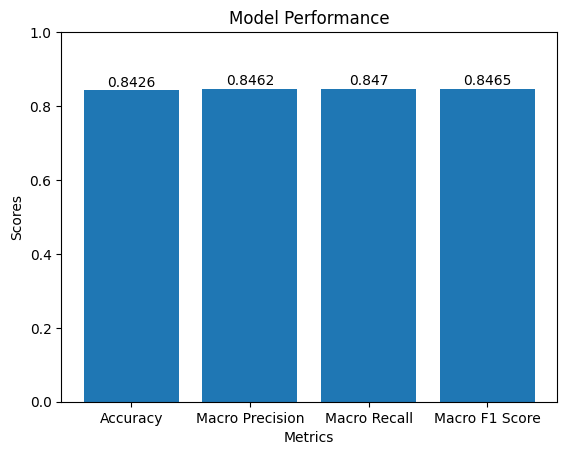

In [8]:
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')
f1 = f1_score(test_labels, predicted_labels, average='macro')

# Create a bar plot to show the obtained results
scores = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1 Score']

# Create the bar plot with colors and value labels
plt.bar(labels, scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance')
plt.ylim(0, 1)

# Add value labels to the top of each bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, round(score, 4), ha='center')

plt.show()


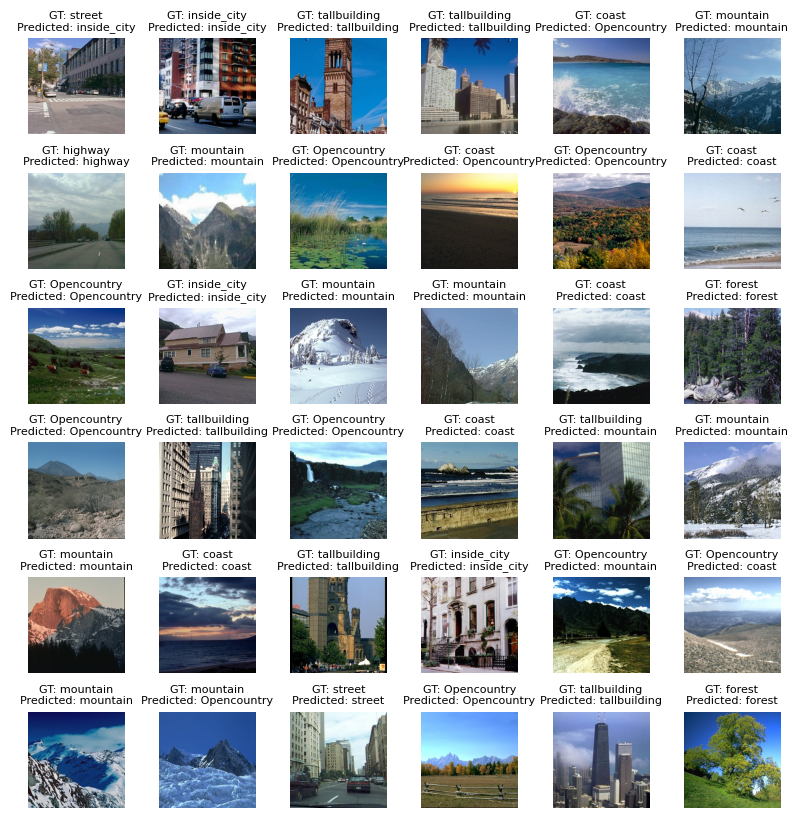

In [9]:
# Show images with predicted and the test labels
plot_images_with_labels(test_images_filenames, predicted_labels, test_labels, 36)

In [ ]:
# Binarize the labels
best_estimator.classifier.classifier.probability = True
train_labels_encoded = LabelBinarizer().fit_transform(train_labels)
test_labels_encoded = LabelBinarizer().fit_transform(test_labels)

# Train the model with the best parameters
classifier = OneVsRestClassifier(best_estimator)
classifier.fit(train_images_filenames, train_labels_encoded)
proba_predicted_labels = classifier.predict_proba(test_images_filenames)


/tmp/ipykernel_15515/2974930126.py:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


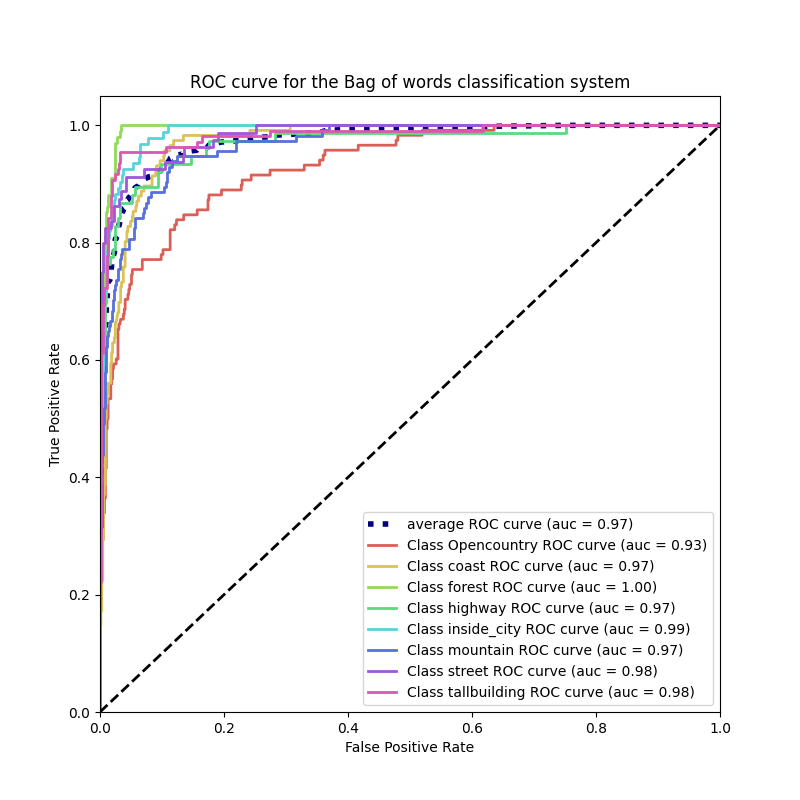

In [29]:
# Compute the ROC curve and ROC area for each class
n_classes = np.unique(train_labels).shape[0]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_encoded[:, i], proba_predicted_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

palette = sns.color_palette("hls", 8)
colors = cycle(palette)
for i, color, name in zip(range(n_classes), colors, np.unique(train_labels)):
    label = 'Class {0} ROC curve (auc = {1:0.2f})'.format(name, roc_auc[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=label)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the Bag of words classification system')
plt.legend(loc="lower right")
plt.show()

## Conclusions:

With the ROC curve of each class, we can see how the model performs depending on the class it has to predict. We can see that the class that it predicts best is the “forest” class, with an auc of almost 1.00, while with the OpenCountry class it has its worse performance, with an auc of 0.93. However, the average ROC curve as an auc of 0.97. 

After all the tests conducted, we have seen how our model slowly got better at classifying the images. The system still has space for improvement, but we have seen that its performance held along the validation and test sets. We can consider our study of the system successful, although we would have like to try with a bigger set of types of descriptors, codebooks and classifiers, had we had more time. 
